# Tutorial 1: Jeans Modeling with Constant Anisotropy
Author: Tri Nguyen

In this tutorial, we will implement a dynamical modeling technique known as Jeans modeling to estimate the mass distribution of a spherical stellar system, such as a globular cluster or a dwarf galaxy.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as units
import astropy.constants as constants

%matplotlib inline

# Loading the data

First, we will load the data with 6D phase-space information of stars in a mock dwarf galaxy. The data contains the 3D positions and velocities of stars (with and without measurement errors).

In [2]:
data = pd.read_csv('AST1420_mock_verr5/CuspIso.csv')
data

,x_kpc,y_kpc,z_kpc,vx_kms,vy_kms,vz_kms,err_vx_kms,err_vy_kms,err_vz_kms,vx_true_kms,vy_true_kms,vz_true_kms
0,-0.123697,0.034911,-0.106114,-5.013957,-2.024634,7.939942,5.0,5.0,5.0,-6.983836,-5.999756,12.627710
1,0.044236,0.035054,-0.077228,-0.674390,-2.065564,15.317643,5.0,5.0,5.0,3.654860,-0.979780,14.524945
2,0.059982,-0.229891,-0.030489,-18.163923,-2.275982,9.711773,5.0,5.0,5.0,-22.405846,4.304961,9.783602
3,0.114244,-0.084136,0.163465,2.764282,3.522927,6.133934,5.0,5.0,5.0,7.881945,-1.469767,8.267711
4,0.127591,-0.075834,-0.302752,-14.719073,5.080674,0.406388,5.0,5.0,5.0,-10.769070,5.302424,1.331642
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.048880,-0.039950,-0.088983,-12.092206,-4.977932,1.594292,5.0,5.0,5.0,-6.885052,-1.318228,-3.184558
96,-0.032607,0.033699,-0.137775,5.254190,5.481316,2.668240,5.0,5.0,5.0,-2.265798,12.563897,2.372953
97,-0.139598,0.068266,-0.067781,-25.339833,12.660986,11.870830,5.0,5.0,5.0,-28.783082,10.301140,2.999065
98,0.825809,-0.978887,0.896628,-10.156788,-9.132695,12.550643,5.0,5.0,5.0,-13.840912,-7.872755,5.741733


In [3]:
true_parameters = pd.read_csv('AST1420_mock_verr5/true_parameters.csv')
true_parameters = true_parameters[true_parameters['Model'] == 'CuspIso']
true_parameters

,Model,DM_Profile,Anisotropy,r_half_kpc,r_a_kpc,gamma,rho_dm,r_dm,beta0
3,CuspIso,Cusp,Isotropic,0.1,10000.0,1.0,64000000.0,1.0,0.0


For this exercise, we will project the 3D positions and velocities onto the x-y plane. 

We will also compute the observed line-of-sight velocity dispersion profile by binning the projected radii. We will not go over this calculation, but you should still go over the implementation in `utils.py` to see how it works.

In [4]:
import utils

In [5]:
R_proj = np.sqrt(data['x_kpc']**2 + data['y_kpc']**2).values
vlos = data['vz_kms'].values
vlos_err = data['err_vz_kms'].values
vlos_true = data['vz_true_kms'].values  # also take the true vlos for comparison

# calculate the binned velocity dispersion
vdisp_binned_res = utils.calc_vdisp_los_binned(
    R_proj, vlos, vlos_err,
    ntracer_per_bin=50,
)

100%|██████████| 2000/2000 [00:00<00:00, 4466.83it/s]


Autocorrelation times: [26.85314879 39.57838689]
Mean tau: 33.2 steps (total chain: 2000 steps)
Discarded 118 steps, thinned by 13
Final sample size: 1152


100%|██████████| 2000/2000 [00:00<00:00, 4498.61it/s]


Autocorrelation times: [17.31226698 29.02619265]
Mean tau: 23.2 steps (total chain: 2000 steps)
Discarded 87 steps, thinned by 8
Final sample size: 1912


100%|██████████| 2000/2000 [00:00<00:00, 4438.09it/s]


Autocorrelation time estimation failed: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [21.72784506 58.23934283]. Extending chain by 2000 steps...


100%|██████████| 2000/2000 [00:00<00:00, 4571.87it/s]


Autocorrelation times: [28.0154342  66.37100798]
Mean tau: 47.2 steps (total chain: 4000 steps)
Discarded 199 steps, thinned by 14
Final sample size: 2168


100%|██████████| 2000/2000 [00:00<00:00, 4606.53it/s]

Autocorrelation times: [24.74514334 28.22066582]
Mean tau: 26.5 steps (total chain: 2000 steps)
Discarded 84 steps, thinned by 12
Final sample size: 1272


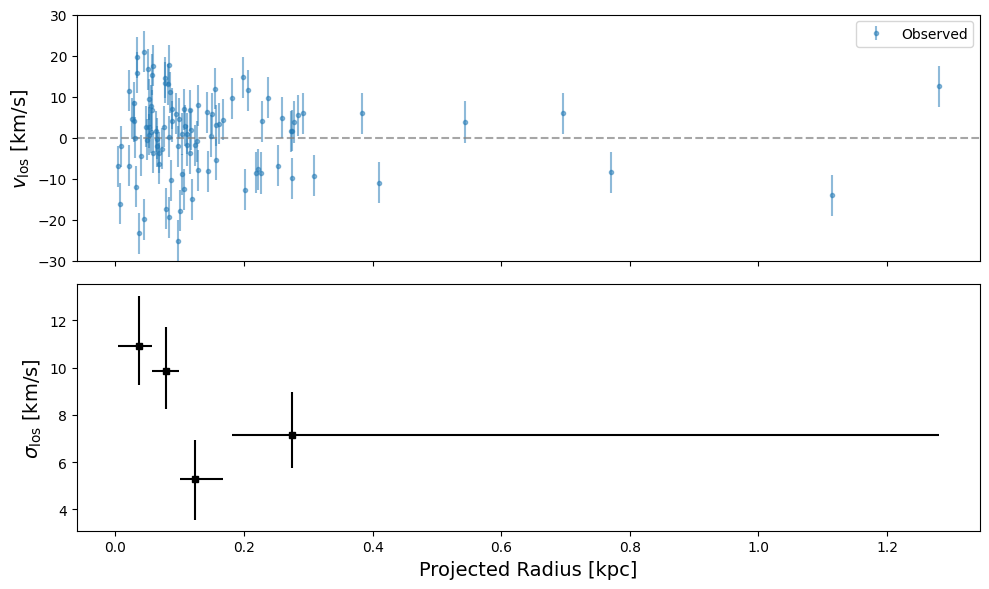

In [6]:
fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True, tight_layout=True)

axes[0].errorbar(R_proj, vlos, yerr=vlos_err, fmt='o', markersize=3, alpha=0.5, label='Observed')
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.7)
axes[0].set_ylabel(r'$v_\mathrm{los}$ [km/s]', fontsize=14)
axes[0].set_ylim(-30, 30)

# plot the binned velocity dispersion
R_mid = vdisp_binned_res['R_mid']
R_em = vdisp_binned_res['R_em']
R_ep = vdisp_binned_res['R_ep']
sigma = vdisp_binned_res['sigma']
sigma_em = vdisp_binned_res['sigma_em']
sigma_ep = vdisp_binned_res['sigma_ep']
axes[1].errorbar(
    R_mid, sigma,
    yerr=[sigma_em, sigma_ep],
    xerr=[R_em, R_ep],
    fmt='s', color='black',
    markersize=4, label='Binned Dispersion')
axes[1].set_ylabel(r'$\sigma_\mathrm{los}$ [km/s]', fontsize=14)
axes[1].set_xlabel('Projected Radius [kpc]', fontsize=14)

axes[0].legend()
plt.show()

## The Spherical Jeans Equation

For a spherically symmetric, collisionless stellar system in dynamical equilibrium, the **Jeans equation** relates the stellar density $\nu(r)$, velocity dispersion, and gravitational potential:

$$
\frac{1}{\nu}\frac{d(\nu \sigma_r^2)}{dr} + \frac{2\beta(r)\sigma_r^2}{r} = -\frac{GM(r)}{r^2}
$$

where:
- $\nu(r)$ is the 3D stellar (tracer) density profile
- $\sigma_r^2(r)$ is the radial velocity dispersion squared
- $M(r)$ is the enclosed mass (dark matter + stars)
- $G$ is the gravitational constant
- $\beta(r) = 1 - \frac{\sigma_t^2(r)}{\sigma_r^2(r)}$ is the velocity anisotropy parameter 
  - $\beta = 0$: isotropic orbits
  - $\beta > 0$: radially biased orbits
  - $\beta < 0$: tangentially biased orbits
  - $\beta = 1$: purely radial orbits
  - $\beta \to -\infty$: purely tangential orbits

### 3D Radial Velocity Dispersion

The solution to the Jeans equation for $\sigma_r^2(r)$ is given by:

$$
\sigma_r^2(r) = \frac{1}{\nu(r) \, g(r)} \int_r^\infty \nu(r') \, g(r') \, \frac{GM(r')}{r'^2} \, dr'
$$

where the function $g(r)$ depends on the anisotropy profile $\beta(r)$:
$$
g(r) = \exp\left(2\int_0^r \frac{\beta(s)}{s} \, ds\right)
$$

For a constant anisotropy profile: $\beta = \beta_0$ and $g(r) = r^{2\beta_0}$.

### Line-of-Sight Velocity Dispersion

Observations measure the **projected** (line-of-sight) velocity dispersion $\sigma_{\rm los}(R)$ at projected radius $R$. This is related to the intrinsic dispersion through an Abel integral:

$$
\sigma_{\rm los}^2(R) = \frac{2}{I(R)} \int_R^\infty \left(1 - \beta\frac{R^2}{r^2}\right) \frac{\nu \sigma_r^2 \, r}{\sqrt{r^2 - R^2}} \, dr
$$

where $I(R)$ is the projected stellar surface density.

### Stellar Density Profile
Throughout this tutorial, we will use the Plummer profile to model the stellar density. The 3D density and projected surface density are given by:

$$
\nu(r) = \frac{3L}{4\pi r_h^3}\left(1 + \frac{r^2}{r_h^2}\right)^{-5/2}
$$
$$
I(R) = \frac{L}{\pi r_h^2}\left(1 + \frac{R^2}{r_h^2}\right)^{-2}
$$

where $L$ is the total luminosity and $r_h$ is the half-light radius. Note that in the Jeans equation, we only need the shape of the stellar density profile, so the normalization $L$ cancels out.

## 1. Fitting a constant Anisotropy Jeans Model

### 1a. Implementing Jeans model
We will first implement a Jeans model with constant velocity anisotropy $\beta = \beta_0$. Your task is to complete the `ConstantAnisotropyJeans` class below by implementing the methods to compute the radial velocity dispersion and line-of-sight velocity dispersion profiles.

In [7]:
import scipy.special as sc
from scipy.interpolate import interp1d
from scipy.integrate import quad


class ConstantAnisotropyJeans:
    """
    A class to model the radial velocity dispersion profile of a spherical and
    isotropic systems using the Jeans equation. Code adapted from Kohei Hayashi.

    Attributes:
        param (list): List of parameters for the model.
        log_rho_s (float): Logarithm (base 10) of rho_s.
        rho_s (float): Scale density [10^7 M_solar/kpc^3].
        log_r_s (float): Logarithm (base 10) of r_s.
        r_s (float): Scale radius [kpc].
        gam (float): Gamma parameter.
        rh (float): Half-light radius [kpc].
        vsys (float): Systemic velocity [km/s].
        r_vec (np.ndarray): Array of radii [kpc] for calculations.
    """
    def __init__(self, theta, beta0, min_radius=1e-3, max_radius=5, n_radius=200):
        """
        Args:
            theta (list): List of parameters for the model.
            beta0 (float): The velocity anisotropy parameter.
            min_radius (float, optional): Minimum radius [kpc]. Defaults to 1e-3.
            max_radius (float, optional): Maximum radius [kpc]. Defaults to 5.
            n_radius (int, optional): Number of radius points. Defaults to 200.
        """
        self.param = theta
        self.log_rho_s = self.param[0]  # log10(rho_s)
        self.rho_s = 10.0 ** self.param[0]  # rho_s [10^7 M_solar/kpc^3]
        self.log_r_s = self.param[1]  # log10(r_s)
        self.r_s = 10.0 ** self.param[1]  # r_s [kpc]
        self.gam = self.param[2]  # gamma
        self.rh = self.param[3]  # r_half [kpc]
        self.vsys = self.param[4]  # Vsys [km/s]
        self.beta0 = beta0  # constant anisotropy parameter

        self.r_vec = np.logspace(np.log10(min_radius), np.log10(max_radius), n_radius)

    def rho(self, r):
        """
        Compute the dark matter density profile for dwarf spheroidal galaxies (dSphs).
        Assume generalized NFW profile with alpha=1 and beta=3.

        Args:
            r (float): Radius [kpc].

        Returns:
            float: Dark matter density at radius r in units of 10^7 M_solar/kpc^3.
        """
        c1 = self.rho_s * (r / self.r_s)**(-self.gam)
        c2 = (1 + (r / self.r_s))**(-(3 - self.gam))
        return c1 * c2

    def M(self, r):
        """
        Compute the dark matter mass profile for dSphs.
        This can be obtained by integrating the density profile, but for the generalized NFW profile,
        there exists an analytical expression.

        Args:
            r (float): Radius [kpc].

        Returns:
            float: Dark matter mass at radius r in units of 10^7 M_solar.
        """
        r_n = r / self.r_s
        c1 = (4 * np.pi * self.rho_s * self.r_s**3) / (3.0 - self.gam)
        c2 = r_n ** (3.0 - self.gam)
        return c1 * c2 * sc.hyp2f1(
            3.0 - self.gam, 3.0 - self.gam, 1.0 + (3.0 - self.gam), -r_n)

    def nu(self, r):
        """
        Compute the 3D stellar density profile assuming a Plummer profile.
        Ignoring mass-to-light ratio, since it cancels out in the Jeans equation.

        Args:
            r (float): Radius [kpc].

        Returns:
            float: Stellar density at radius r.
        """
        return 3.0 / (4.0 * np.pi * self.rh**3) * (1 + (r / self.rh)**2)**(-2.5)

    def I(self, R):
        """
        Compute the projected stellar density profile assuming a Plummer profile.

        Args:
            R (float): Projected radius [kpc].

        Returns:
            float: Projected stellar density at radius R.
        """
        return 1.0 / (np.pi * self.rh**2) * (1 + (R / self.rh)**2)**(-2)

    def beta(self, r):
        """
        Velocity anisotropy parameter (isotropic case).

        Args:
            r (float): Radius [kpc].

        Returns:
            float: Velocity anisotropy parameter at radius r.
        """
        return self.beta0

    def gbeta(self, r):
        """
        Compute the function g(r) related to the velocity anisotropy.

        Args:
            r (float): Radius [kpc].

        Returns:
            float: g(r) value at radius r.
        """
        return r**(2 * self.beta0)

    # =========================================================================
    # TODO: Implement the two methods below (_sigma2_r and _sigma2_los_R).
    #
    # These are "private" helper methods (prefixed with _) that compute the
    # velocity dispersion at a SINGLE radius. The public methods (sigma2 and
    # sigma2_los) handle vectorization by calling these helpers over a grid
    # of radii and building an interpolator for efficiency.
    #
    # This separation allows you to focus on the physics (the integrals) in
    # the private methods, while the public methods handle the numerical
    # details of interpolation.
    # =========================================================================

    def _sigma2_r(self, r):
        """
        Compute the radial velocity dispersion squared at a single radius r.

        TODO: Implement the Jeans equation solution for sigma_r^2(r):
            sigma_r^2(r) = (1 / (nu * g)) * integral_r^inf [ nu(s) * g(s) * G*M(s)/s^2 ] ds

        Hint: Define an integrand function and use scipy.integrate.quad.
        Use self.nu(), self.gbeta(), self.M(), and constants.G.value.
        Make sure to convert units appropriately to get the final result in [km^2/s^2].

        Args:
            r (float): Radius [kpc].

        Returns:
            float: Radial velocity dispersion squared at radius r in units of [km^2/s^2].
        """
        def integrand(s):
            return constants.G.value * self.M(s) / s**2 * self.nu(s) * self.gbeta(s)

        c1 = 1.0 / (self.nu(r) * self.gbeta(r))
        integral, _ = quad(integrand, r, np.inf, epsabs=1, epsrel=1)
        to_km2_s2 = 1.989 * 1e12 / 3.0856
        return c1 * integral * to_km2_s2

    def _sigma2_los_R(self, R, sigma2_r_fn):
        """
        Compute the line-of-sight velocity dispersion squared at a single projected radius R.

        TODO: Implement the Abel integral projection:
            sigma_los^2(R) = (2 / I(R)) * integral_R^inf [ (1 - beta*R^2/r^2) * nu * sigma_r^2 * r / sqrt(r^2 - R^2) ] dr

        Hint: The integrand has three parts:
            1. anisotropy_term = 1 - beta * (R/r)^2
            2. kernel = r / sqrt(r^2 - R^2)
            3. density and dispersion = nu(r) * sigma2_r_fn(r)

        Args:
            R (float): Projected radius [kpc].
            sigma2_r_fn (callable): Interpolated function for sigma_r^2(r).

        Returns:
            float: Line-of-sight velocity dispersion squared at radius R in units of [km^2/s^2].
        """
        def integrand(r):
            anisotropy_term = 1 - self.beta0 * (R / r)**2
            kernel = r / np.sqrt(r**2 - R**2)
            return anisotropy_term * self.nu(r) * sigma2_r_fn(r) * kernel

        integral, _ = quad(integrand, R, np.inf, epsabs=1, epsrel=1)
        return 2.0 / self.I(R) * integral

    # =========================================================================
    # Public methods below: these handle vectorization and interpolation.
    # You do NOT need to modify these.
    # =========================================================================

    def sigma2(self, r_vec):
        """
        Compute sigma_r^2 over an array of radii and return an interpolator.

        This method evaluates _sigma2_r at each radius in r_vec, then returns
        an interpolated function for fast evaluation at arbitrary radii.

        Args:
            r_vec (array-like): Array of radii [kpc].

        Returns:
            callable: Interpolated function for radial velocity dispersion squared.
        """
        return interp1d(
            r_vec,
            list(map(self._sigma2_r, r_vec)),
            bounds_error=False,
            fill_value=0.0,
            kind="linear",
        )

    def sigma2_los(self, min_radius=1e-3):
        """
        Compute the line-of-sight velocity dispersion profile.

        Args:
            min_radius (float, optional): Minimum radius [kpc]. Defaults to 1e-3.

        Returns:
            np.ndarray: Array of line-of-sight velocity dispersion values.
        """
        # Pre-compute sigma_r^2 on a fine grid and interpolate
        r_grid = np.logspace(np.log10(min_radius), np.log10(50), 500)
        sigma2_r_fn = self.sigma2(r_grid)

        # Compute sigma_los^2 at each projected radius
        sigma2_los = np.array([
            self._sigma2_los_R(R, sigma2_r_fn) for R in self.r_vec
        ])
        return sigma2_los

In [8]:
# =============================================================================
# Test: Verify your implementation of _sigma2_r and _sigma2_los_R
# =============================================================================
def test_jeans_implementation():
    """Test the private helper methods that students implement."""

    theta = [0.0, 0.0, 1.0, 0.3, 0.0]  # rho_s=1, r_s=1, gamma=1, r_half=0.3

    # ----- Test _sigma2_r -----
    model = ConstantAnisotropyJeans(theta, beta0=0.0)
    sigma2_r_val = model._sigma2_r(0.5)
    assert np.isclose(sigma2_r_val, 21.618770, rtol=1e-3), \
        f"_sigma2_r(0.5) failed: got {sigma2_r_val:.6e}, expected 21.618770"

    # ----- Test _sigma2_los_R -----
    # Build interpolator for sigma2_r to pass to _sigma2_los_R
    r_grid = np.logspace(-3, 2, 500)
    sigma2_r_fn = model.sigma2(r_grid)

    sigma2_los_val = model._sigma2_los_R(0.1, sigma2_r_fn)
    assert np.isclose(sigma2_los_val, 24.642838, rtol=1e-3), \
        f"_sigma2_los_R(0.1) failed: got {sigma2_los_val:.6e}, expected 24.642838"

    print("All tests passed!")

test_jeans_implementation()

All tests passed!


### 1b. Defining the likelihood function

To fit the Jeans model to observational data, we need to define a **likelihood function** that quantifies how well a given set of model parameters explains the observed velocities.

For each star $i$ at projected radius $R_i$ with observed line-of-sight velocity $v_i$ and measurement error $\sigma_{\rm err,i}$, we assume the velocity is drawn from a Gaussian distribution:

$$
v_i \sim \mathcal{N}\left(v_{\rm sys}, \, \sigma_{\rm los}^2(R_i; \theta) + \sigma_{\rm err,i}^2\right)
$$

where:
- $v_{\rm sys}$ is the systemic velocity of the galaxy
- $\sigma_{\rm los}^2(R_i)$ is the intrinsic line-of-sight velocity dispersion from the Jeans model
- $\sigma_{\rm err,i}^2$ is the measurement uncertainty (added in quadrature)
- $\theta$ represents density profile parameters, half-light radius, anisotropy parameter, etc.

The **log-likelihood** of observing the velocity $v_i$ at radius $R_i$ is given by

$$
\ln \mathcal{N}\left(v_i \,|\, v_{\rm sys}, \sqrt{\sigma_{\rm los}^2(R_i) + \sigma_{\rm err,i}^2}\right) = -\frac{1}{2} \left[ \frac{(v_i - v_{\rm sys})^2}{\sigma_{\rm los}^2(R_i; \theta) + \sigma_{\rm err,i}^2} + \ln\left(2\pi \left(\sigma_{\rm los}^2(R_i; \theta) + \sigma_{\rm err,i}^2\right)\right) \right]
$$

Under the *assumption that the observations are independent*, the log-likelihood for all $N$ stars is the sum of the individual log-probabilities:

$$
\ln \mathcal{L}(\theta) = \sum_{i=1}^{N} \ln \mathcal{N}\left(v_i \,|\, v_{\rm sys}, \sqrt{\sigma_{\rm los}^2(R_i; \theta) + \sigma_{\rm err,i}^2}\right)
$$


For this exercise, you will complete the `log_likelihood` function below. The log-likehood function takes in the model parameters and observational data, computes the model line-of-sight velocity dispersion profile, and evaluates the log-likelihood of the observed velocities given the model. It should return the total log-likelihood value, and negative infinity if any model parameters are unphysical (e.g., negative mass or half-light radius).

In [9]:
from scipy.stats import uniform, norm

In [10]:
def log_likelihood(theta, r_obs, v_obs, v_err_obs, beta0=0.0):
    """
    Compute the log likelihood for the Jeans model given observational data.

    TODO: Implement the Gaussian log-likelihood

    Args:
        theta (np.ndarray): Model parameters [log_rho_s, log_r_s, gam, log_rb, rh, vsys].
        r_obs (np.ndarray): Observed projected radii [kpc].
        v_obs (np.ndarray): Observed line-of-sight velocities [km/s].
        v_err_obs (np.ndarray): Velocity measurement errors [km/s].
        beta0 (float): Velocity anisotropy parameter. Defaults to 0.0 (isotropic).

    Returns:
        float: Log likelihood value, or -inf if model is invalid.
    """
    # compute the dispersion sigma2_los on the model grid and interpolate to observed radii
    model = ConstantAnisotropyJeans(theta, beta0)
    sigma2_los_grid = model.sigma2_los()
    sigma2_los_fn = interp1d(
        model.r_vec, sigma2_los_grid,
        bounds_error=False, fill_value=0.0, kind="linear"
    )
    sigma2_los = sigma2_los_fn(r_obs)

    # check for invalid dispersion values, this can happen if params are unphysical
    if np.any(sigma2_los < 0):
        return -np.inf

    # compute total variance (intrinsic + measurement error) and the log-likelihood
    # note how the variance is added in quadrature
    sigma2_tot = sigma2_los + v_err_obs**2
    lnlike = norm.logpdf(v_obs, loc=model.vsys, scale=np.sqrt(sigma2_tot))

    if np.any(~np.isfinite(lnlike)):
        return -np.inf

    return lnlike.sum()

In [11]:
# =============================================================================
# Test: Verify your log_likelihood implementation
# =============================================================================
def test_log_likelihood():
    """Test the log_likelihood function with known reference values."""

    theta_test = [0.0, 0.0, 1.0, 0.3, 0.0]  # vsys = 0
    r_obs = np.array([0.1, 0.3, 0.5, 0.8, 1.0])
    v_obs = np.array([5.0, -3.0, 2.0, -1.0, 4.0])
    v_err = np.array([5.0, 5.0, 5.0, 5.0, 5.0])
    ll = log_likelihood(theta_test, r_obs, v_obs, v_err, beta0=0.0)
    assert np.isclose(ll, -14.807000, rtol=1e-3), \
        f"log_likelihood failed: got {ll:.6f}, expected -14.807000"

    print("Likelihood tests passed!")

# Run the test
test_log_likelihood()

Likelihood tests passed!


### 1c. Fitting the model to data
Once we have defined the likelihood function, we can use a sampling algorithm to explore the posterior distribution of the model parameters given the data. We will use the `pocomc` package to perform Markov Chain Monte Carlo (MCMC) sampling, but you can also use other libraries such as `emcee` or `dynesty` (you might have to adapt the likelihood function accordingly though).

In [12]:
import multiprocess as mp
import pocomc as pc

First, we define the prior distribution as uniform priors on the model parameters within reasonable bounds. 

In [13]:
class UniformPrior():
    def __init__(self, name, low, high):
        self.name = name
        self.low = low
        self.high = high
        self.dist = uniform(loc=low, scale=high - low)

    def logpdf(self, x):
        return self.dist.logpdf(x)

    def rvs(self, size=1):
        return self.dist.rvs(size=size)

# Constructing priors
# NOTE: often, it is better to measure r_half from photometric data and vary it
# within a few error bars, rather than treating it as a completely free parameter.
# Here, we set a narrow prior around the true r_half value used in the mock data.
r_half_kpc = true_parameters['r_half_kpc'].values[0]
priors = dict(
    log_rho_s=UniformPrior("log_rho_s", -3.0, 3.0),  # 10^7 M_sun/kpc^3
    log_r_s=UniformPrior("log_r_s", -3.0, 3.0),  # kpc
    gam=UniformPrior("gam", 0.0, 1.5),
    rh=UniformPrior("rh", r_half_kpc - 0.1, r_half_kpc + 0.1),
    vsys=UniformPrior("vsys", -1e3, 1e3),
)
# make sure order matches theta in model
prior_list = [priors[key].dist for key in ["log_rho_s", "log_r_s", "gam", "rh", "vsys"]]

# create pocomc Prior object
pc_priors = pc.Prior(prior_list)

We can now run the MCMC sampler. This should take about 10-20 minutes depending on your machine. I ran this with 32 walkers and 5000 steps, and it took me about 11 minutes on my laptop.

In [14]:
# Run sampler
n_cpus = 32  # set to None to use all available CPUs, to use all CPUs, use mp.cpu_count()
n_total = 2000 # total number of MCMC samples

print(f"\nRunning sampler with {n_cpus} CPUs, n_total={n_total} samples...\n")

with mp.Pool(n_cpus) as pool:
    sampler = pc.Sampler(
        prior=pc_priors,
        likelihood=log_likelihood,
        likelihood_kwargs=dict(
            r_obs=R_proj,
            v_obs=vlos,
            v_err_obs=vlos_err,
            beta0=0.0
        ),
        pool=pool,
        vectorize=False,
    )
    sampler.run(n_total=n_total, progress=True)
    samples_arr, logl, logp = sampler.posterior(resample=True)


Running sampler with 32 CPUs, n_total=2000 samples...



Iter: 26it [04:34, 10.56s/it, beta=1, calls=27904, ESS=1763, logZ=-382, logP=-381, acc=0.231, steps=4, eff=0.929]        


After the sampling is complete, we can analyze the posterior samples to estimate the best-fit parameters and their uncertainties. We can also visualize the results by plotting the observed velocity dispersion profile along with the model predictions.

First, we can examine the corner plot of the posterior distributions of the model parameters.

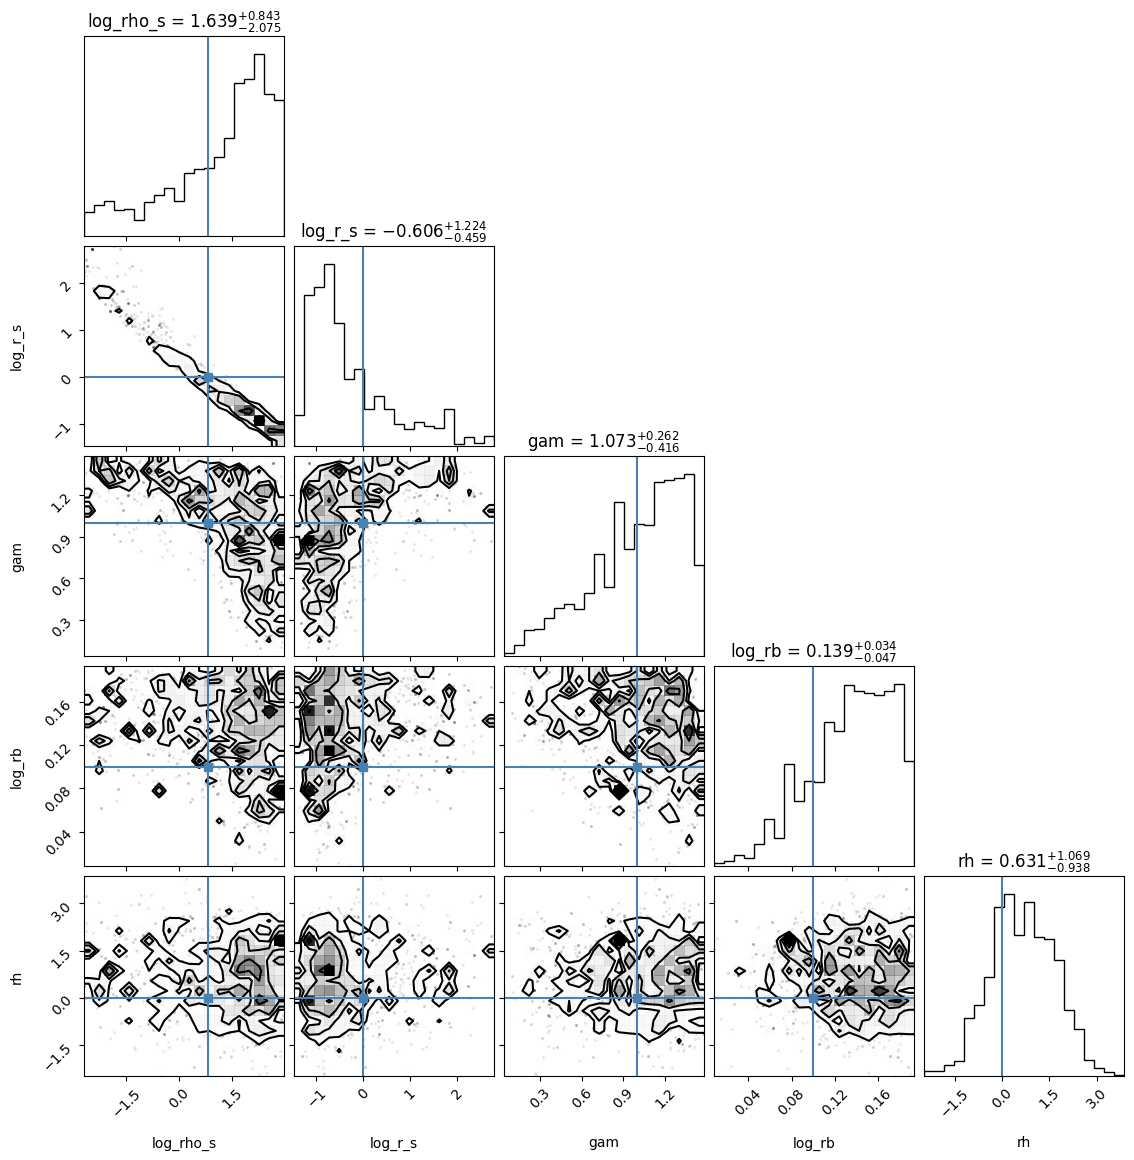

In [15]:
import corner

theta_true = np.array([
    np.log10(true_parameters['rho_dm'].values[0]) - 7,  # convert to 10^7 M_sun/kpc^3
    np.log10(true_parameters['r_dm'].values[0]),
    true_parameters['gamma'].values[0],
    true_parameters['r_half_kpc'].values[0],
    0
])

# plot corner plots
fig = corner.corner(
    samples_arr,
    labels=["log_rho_s", "log_r_s", "gam", "log_rb", "rh", "vsys"],
    truths=theta_true,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
)

We can also calculate the posterior of the dark matter density profile, enclosed mass profile, and velocity dispersion profile.

In [16]:
r_plot = np.logspace(-2, 2, 50)  # same as model.r_vec below
num_max_samples = 500  # limit number of samples to plot for speed
samples_choice = np.random.choice(
    samples_arr.shape[0], size=num_max_samples, replace=False)

# this will take 30-40 seconds
rho_dm_samples = np.zeros((num_max_samples, len(r_plot)))
mass_dm_samples = np.zeros((num_max_samples, len(r_plot)))
vdisp_samples = np.zeros((num_max_samples, len(r_plot)))

for i, theta_sample in enumerate(samples_arr[samples_choice]):
    model = ConstantAnisotropyJeans(
        theta_sample, beta0=0.0, min_radius=0.01, max_radius=100, n_radius=50)
    rho_dm_samples[i] = model.rho(r_plot)
    mass_dm_samples[i] = model.M(r_plot)
    vdisp_samples[i] = np.sqrt(model.sigma2_los())

# also calculate the true profiles
true_model = ConstantAnisotropyJeans(
    theta_true, beta0=0.0, min_radius=0.01, max_radius=100, n_radius=50)
rho_dm_true = true_model.rho(r_plot)
mass_dm_true = true_model.M(r_plot)
vdisp_true = np.sqrt(true_model.sigma2_los())

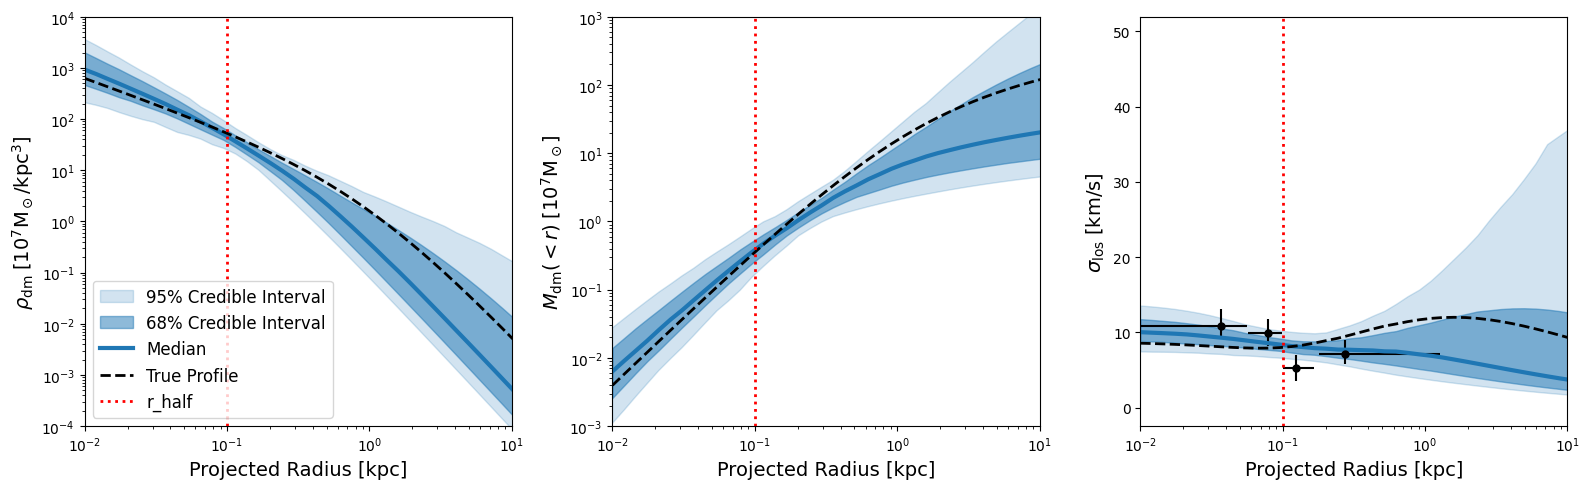

In [17]:
percentiles = [2, 16, 50, 84, 98]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), tight_layout=True, sharex=True)

# ---- Dark Matter Density Profile ----
ax = axes[0]
rho_dm_q = np.percentile(rho_dm_samples, percentiles, axis=0)
ax.fill_between(
    r_plot, rho_dm_q[0], rho_dm_q[4], color='C0', alpha=0.2,
    label='95% Credible Interval')
ax.fill_between(
    r_plot, rho_dm_q[1], rho_dm_q[3], color='C0', alpha=0.5,
    label='68% Credible Interval')
ax.plot(r_plot, rho_dm_q[2], color='C0', linestyle='-', lw=3, label='Median')
ax.plot(r_plot, rho_dm_true, color='black', linestyle='--', lw=2, label='True Profile')
ax.set_xlim(0.01, 10)
ax.set_ylim(1e-4, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Projected Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\rho_\mathrm{dm} \; [10^7 \mathrm{M_\odot/kpc^3}]$', fontsize=14)

# ---- Enclosed Mass Profile ----
ax = axes[1]
mass_dm_q = np.percentile(mass_dm_samples, percentiles, axis=0)
ax.fill_between(
    r_plot, mass_dm_q[0], mass_dm_q[4], color='C0', alpha=0.2,
    label='95% Credible Interval')
ax.fill_between(
    r_plot, mass_dm_q[1], mass_dm_q[3], color='C0', alpha=0.5,
    label='68% Credible Interval')
ax.plot(r_plot, mass_dm_q[2], color='C0', linestyle='-', lw=3, label='Median')
ax.plot(r_plot, mass_dm_true, color='black', linestyle='--', lw=2, label='True Profile')
ax.set_xlim(0.01, 10)
ax.set_ylim(1e-3, 1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Projected Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$M_\mathrm{dm}(<r) \; [10^7 \mathrm{M_\odot}]$', fontsize=14)

# ---- Velocity Dispersion Profile ----
# for this panel, also plot the binned data
ax = axes[2]
ax.errorbar(
    R_mid, sigma,
    yerr=[sigma_em, sigma_ep],
    xerr=[R_em, R_ep],
    fmt='o', color='black',
    markersize=5, label='Binned Dispersion'
)
vdisp_q = np.percentile(vdisp_samples, percentiles, axis=0)
ax.fill_between(
    r_plot, vdisp_q[0], vdisp_q[4], color='C0', alpha=0.2,
    label='95% Credible Interval')
ax.fill_between(
    r_plot, vdisp_q[1], vdisp_q[3], color='C0', alpha=0.5,
    label='68% Credible Interval')
ax.plot(r_plot,vdisp_q[2],color='C0',linestyle='-', lw=3, label='Median')
ax.plot(r_plot, vdisp_true, color='black', linestyle='--', lw=2, label='True Profile')
ax.set_xlabel('Projected Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\sigma_\mathrm{los}$ [km/s]', fontsize=14)

# for each panel, mark the half-light radius
for ax in axes:
    ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2, label='r_half')

axes[0].legend(fontsize=12)
plt.show()

Your posterior profiles should go through your data points within uncertainties. However, it does not mean that it will recover the true parameters used to generate the mock data, due to sampling variance and degeneracies between model parameters.

In this case, there is no mass-anisotropy degeneracy, since we assumed the correct anisotropy model (isotropic $\beta=0$ at all radii). Things you can try to explore the mass-anisotropy degeneracy include:
- Fitting with an incorrect value of $\beta$ (e.g., $\beta=0.5$ or $\beta=-0.5$) and see how it affects the inferred mass profile.
- Allowing $\beta$ to be a free parameter in the fit and see how it correlates with the mass profile, which we will do in the example below.

## 2. Fitting with Free Anisotropy Parameter

In this section, we will extend our analysis by treating the velocity anisotropy $\beta_0$ as a free parameter. This allows us to explore the **mass-anisotropy degeneracy**, which is a fundamental limitation of Jeans modeling: different combinations of mass profile and anisotropy can produce similar line-of-sight velocity dispersion profiles.

### 2a. Modified likelihood function

We need to modify our likelihood function to include $\beta_0$ as part of the parameter vector $\theta$. We will use a uniform prior on $2^{\beta_0}$ rather than on $\beta_0$ directly. This choice:
- Gives equal weight to tangential ($\beta < 0$) and radial ($\beta > 0$) anisotropy
- Provides a natural parameterization since $g(r) = r^{2\beta_0}$

The transformation is: if $x \sim \text{Uniform}(a, b)$, then $\beta_0 = \log_2(x)$.

In [18]:
def log_likelihood_free_beta(theta, r_obs, v_obs, v_err_obs):
    """
    Compute the log likelihood for the Jeans model with free anisotropy parameter.

    TODO: Implement the Gaussian log-likelihood with free beta parameter.

    Hint: Make the last parameter in theta represent 2^beta and follow the likelihood
    implementation as the previous one.

    Args:
        theta (np.ndarray): Model parameters [log_rho_s, log_r_s, gam, rh, vsys, two_to_beta].
            Note: the last parameter is 2^beta, not beta directly.
        r_obs (np.ndarray): Observed projected radii [kpc].
        v_obs (np.ndarray): Observed line-of-sight velocities [km/s].
        v_err_obs (np.ndarray): Velocity measurement errors [km/s].

    Returns:
        float: Log likelihood value, or -inf if model is invalid.
    """
    theta_jeans = theta[:5]  # [log_rho_s, log_r_s, gam, rh, vsys]
    two_to_beta0 = theta[5]  # 2^beta0
    beta0 = np.log2(two_to_beta0)

    # beta0 is constrained to between -infinity and 1
    if beta0 >= 1.0:
        return -np.inf

    # Compute the dispersion sigma2_los on the model grid and interpolate to observed radii
    model = ConstantAnisotropyJeans(theta_jeans, beta0)
    sigma2_los_grid = model.sigma2_los()
    sigma2_los_fn = interp1d(
        model.r_vec, sigma2_los_grid,
        bounds_error=False, fill_value=0.0, kind="linear"
    )
    sigma2_los = sigma2_los_fn(r_obs)

    # Check for invalid dispersion values
    if np.any(sigma2_los <= 0):
        return -np.inf

    # Compute total variance and the log-likelihood
    # note how the variance is added in quadrature
    sigma2_tot = sigma2_los + v_err_obs**2
    lnlike = norm.logpdf(v_obs, loc=model.vsys, scale=np.sqrt(sigma2_tot))

    if np.any(~np.isfinite(lnlike)):
        return -np.inf

    return lnlike.sum()

In [19]:
# =============================================================================
# Test: Verify your log_likelihood_free_beta implementation
# =============================================================================
def test_log_likelihood_free_beta():
    """Test the log_likelihood_free_beta function with known reference values."""

    # theta = [log_rho_s, log_r_s, gam, rh, vsys, 2^beta]
    # For beta=0, 2^beta = 1.0
    theta_test_iso = [0.0, 0.0, 1.0, 0.3, 0.0, 1.0]  # isotropic (beta=0)
    r_obs = np.array([0.1, 0.3, 0.5, 0.8, 1.0])
    v_obs = np.array([5.0, -3.0, 2.0, -1.0, 4.0])
    v_err = np.array([5.0, 5.0, 5.0, 5.0, 5.0])

    ll_iso = log_likelihood_free_beta(theta_test_iso, r_obs, v_obs, v_err)
    assert np.isclose(ll_iso, -14.807000, rtol=1e-3), \
        f"log_likelihood_free_beta (iso) failed: got {ll_iso:.6f}, expected -14.807000"  # TODO: fill in

    # For beta=0.3, 2^beta = 2^0.3 ≈ 1.231
    theta_test_rad = [0.0, 0.0, 1.0, 0.3, 0.0, 2**0.3]  # radially biased (beta=0.3)
    ll_radial = log_likelihood_free_beta(theta_test_rad, r_obs, v_obs, v_err)
    assert np.isclose(ll_radial, -14.750110, rtol=1e-3), \
        f"log_likelihood_free_beta (radial) failed: got {ll_radial:.6f}, expected -14.750110"  # TODO: fill in

    # For beta=-0.5, 2^beta = 2^(-0.5) ≈ 0.707
    theta_test_tan = [0.0, 0.0, 1.0, 0.3, 0.0, 2**(-0.5)]  # tangentially biased (beta=-0.5)
    ll_tang = log_likelihood_free_beta(theta_test_tan, r_obs, v_obs, v_err)
    assert np.isclose(ll_tang, -14.868856, rtol=1e-3), \
        f"log_likelihood_free_beta (tang) failed: got {ll_tang:.6f}, expected -14.868856"  # TODO: fill in

    print("Likelihood tests passed!")

# Run the test
test_log_likelihood_free_beta()

Likelihood tests passed!


### 2b. Running the MCMC sampler with free anisotropy

We now add a prior on $2^{\beta_0}$. The choice of bounds determines the range of allowed anisotropy:
- $2^{\beta_0} \in [0.25, 2]$ corresponds to $\beta_0 \in [-2, 1]$
- This covers strongly tangential ($\beta = -2$) to nearly radial ($\beta = 1$) orbits

In [20]:
# Constructing priors with free beta
priors_free_beta = dict(
    log_rho_s=UniformPrior("log_rho_s", -3.0, 3.0),  # 10^7 M_sun/kpc^3
    log_r_s=UniformPrior("log_r_s", -3.0, 3.0),  # kpc
    gam=UniformPrior("gam", 0.0, 1.5),
    rh=UniformPrior("rh", r_half_kpc - 0.1, r_half_kpc + 0.1),
    vsys=UniformPrior("vsys", -1e3, 1e3),
    two_to_beta=UniformPrior("two_to_beta", 0.25, 2.0),  # 2^beta, corresponds to beta in [-2, 1]
)

# make sure order matches theta in model
prior_list_free_beta = [
    priors_free_beta[key].dist for key in
    ["log_rho_s", "log_r_s", "gam", "rh", "vsys", "two_to_beta"]
]

# create pocomc Prior object
pc_priors_free_beta = pc.Prior(prior_list_free_beta)

We run the MCMC sampler again with the modified likelihood and prior. This will take slightly longer due to the additional parameter.

In [21]:
# Run sampler with free beta
n_cpus = 32
n_total = 2000

print(f"\nRunning sampler with free beta, {n_cpus} CPUs, n_total={n_total} samples...\n")

with mp.Pool(n_cpus) as pool:
    sampler_free_beta = pc.Sampler(
        prior=pc_priors_free_beta,
        likelihood=log_likelihood_free_beta,
        likelihood_kwargs=dict(
            r_obs=R_proj,
            v_obs=vlos,
            v_err_obs=vlos_err,
        ),
        pool=pool,
        vectorize=False,
    )
    sampler_free_beta.run(n_total=n_total, progress=True)
    samples_free_beta, logl_free_beta, logp_free_beta = sampler_free_beta.posterior(resample=True)


Running sampler with free beta, 32 CPUs, n_total=2000 samples...



Iter: 26it [05:08, 11.88s/it, beta=1, calls=30464, ESS=1823, logZ=-382, logP=-382, acc=0.415, steps=3, eff=1]         


### 2c. Analyzing the posterior with free anisotropy

Let's examine the corner plot to see the posterior distributions and any correlations between parameters, particularly between the mass parameters and anisotropy.

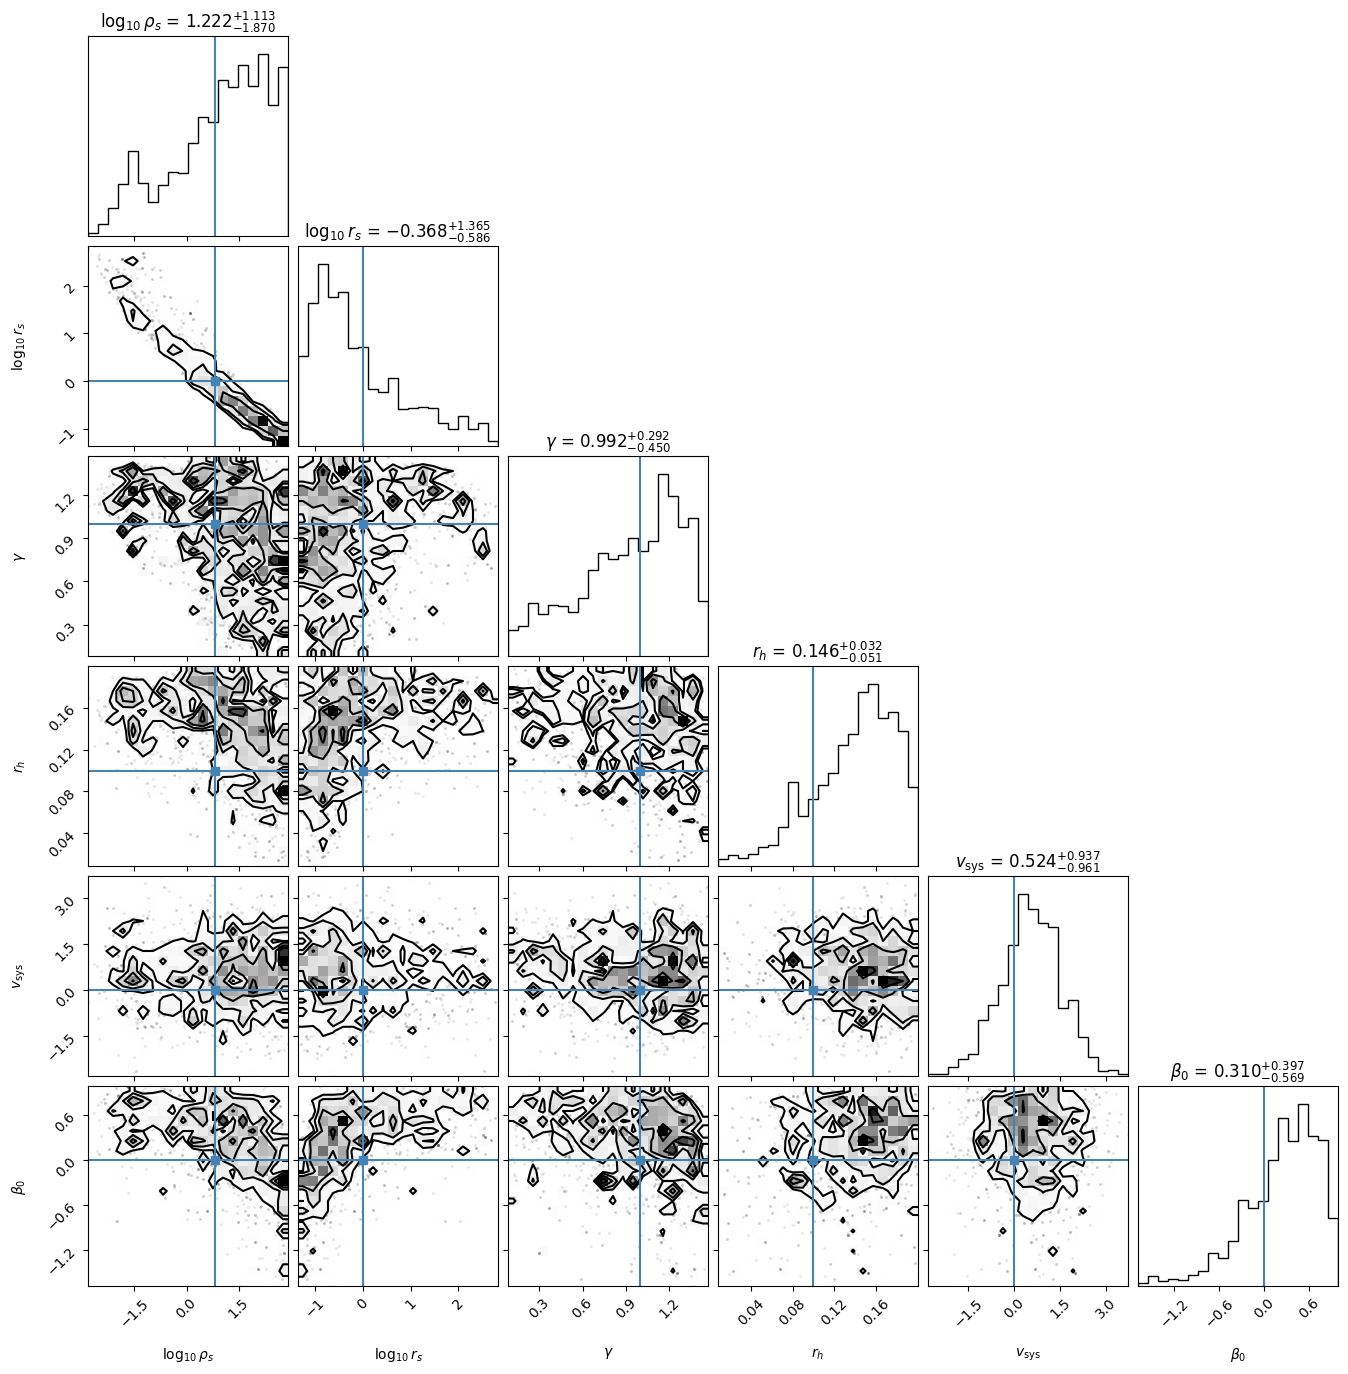

In [22]:
# Convert 2^beta samples to beta for plotting
samples_free_beta_plot = samples_free_beta.copy()
samples_free_beta_plot[:, 5] = np.log2(samples_free_beta[:, 5])  # convert 2^beta to beta

theta_true_free_beta = np.array([
    np.log10(true_parameters['rho_dm'].values[0]) - 7,
    np.log10(true_parameters['r_dm'].values[0]),
    true_parameters['gamma'].values[0],
    true_parameters['r_half_kpc'].values[0],
    0,  # vsys
    true_parameters['beta0'].values[0],  # true beta
])

# plot corner plots
fig = corner.corner(
    samples_free_beta_plot,
    labels=[r"$\log_{10}\rho_s$", r"$\log_{10}r_s$", r"$\gamma$", r"$r_h$", r"$v_{\rm sys}$", r"$\beta_0$"],
    truths=theta_true_free_beta,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
)

In [ ]:
# Compute posterior profiles with free beta
r_plot = np.logspace(-2, 2, 50)
num_max_samples = 500
samples_choice_fb = np.random.choice(
    samples_free_beta.shape[0], size=num_max_samples, replace=False)

rho_dm_samples_fb = np.zeros((num_max_samples, len(r_plot)))
mass_dm_samples_fb = np.zeros((num_max_samples, len(r_plot)))
vdisp_samples_fb = np.zeros((num_max_samples, len(r_plot)))

for i, theta_sample in enumerate(samples_free_beta[samples_choice_fb]):
    theta_jeans = theta_sample[:5]
    beta0 = np.log2(theta_sample[5])  # convert 2^beta to beta
    model = ConstantAnisotropyJeans(
        theta_jeans, beta0=beta0, min_radius=0.01, max_radius=100, n_radius=50)
    rho_dm_samples_fb[i] = model.rho(r_plot)
    mass_dm_samples_fb[i] = model.M(r_plot)
    vdisp_samples_fb[i] = np.sqrt(model.sigma2_los())

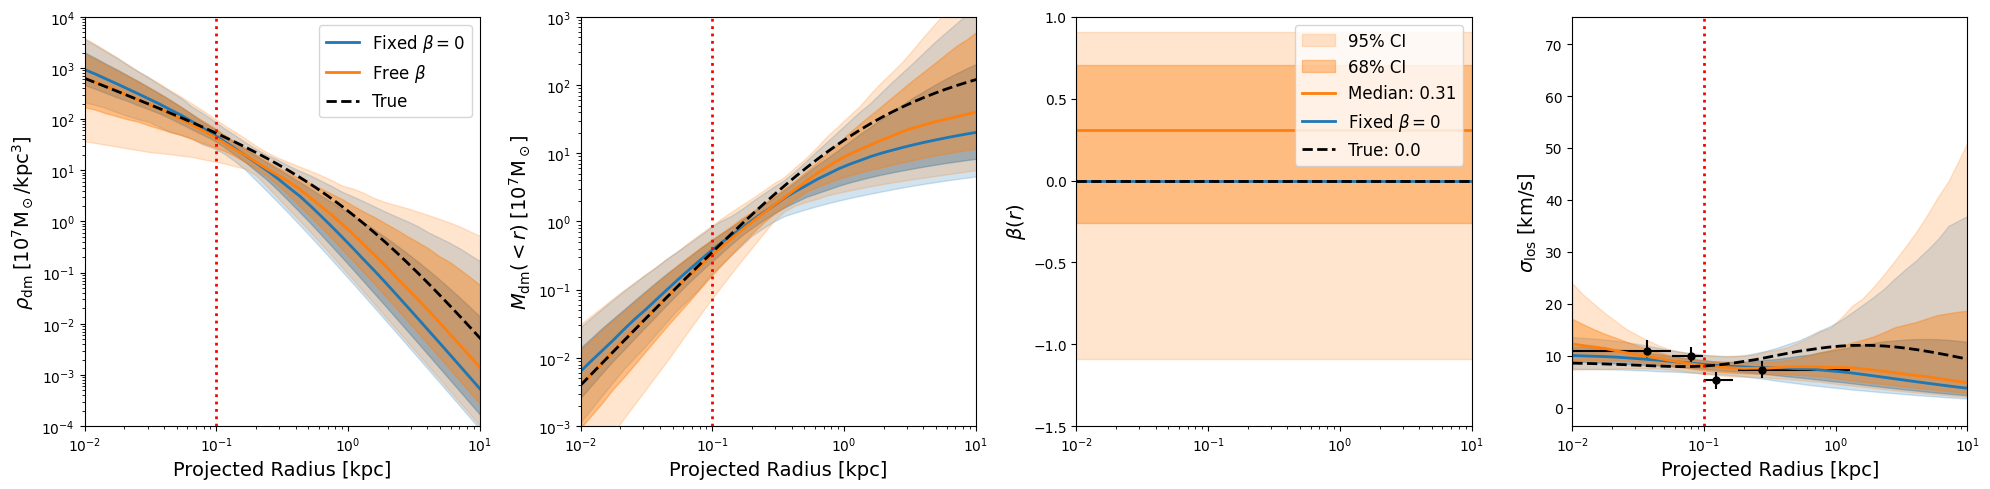

In [24]:
percentiles = [2, 16, 50, 84, 98]

fig, axes = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True, sharex=True)

# ---- Dark Matter Density Profile ----
ax = axes[0]
# Fixed beta (Section 1)
rho_dm_q = np.percentile(rho_dm_samples, percentiles, axis=0)
ax.fill_between(r_plot, rho_dm_q[0], rho_dm_q[4], color='C0', alpha=0.2)
ax.fill_between(r_plot, rho_dm_q[1], rho_dm_q[3], color='C0', alpha=0.4)
ax.plot(r_plot, rho_dm_q[2], color='C0', linestyle='-', lw=2, label=r'Fixed $\beta=0$')
# Free beta (Section 2)
rho_dm_q_fb = np.percentile(rho_dm_samples_fb, percentiles, axis=0)
ax.fill_between(r_plot, rho_dm_q_fb[0], rho_dm_q_fb[4], color='C1', alpha=0.2)
ax.fill_between(r_plot, rho_dm_q_fb[1], rho_dm_q_fb[3], color='C1', alpha=0.4)
ax.plot(r_plot, rho_dm_q_fb[2], color='C1', linestyle='-', lw=2, label=r'Free $\beta$')
# True
ax.plot(r_plot, rho_dm_true, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_ylim(1e-4, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Projected Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\rho_\mathrm{dm} \; [10^7 \mathrm{M_\odot/kpc^3}]$', fontsize=14)
ax.legend(fontsize=12)

# ---- Enclosed Mass Profile ----
ax = axes[1]
# Fixed beta
mass_dm_q = np.percentile(mass_dm_samples, percentiles, axis=0)
ax.fill_between(r_plot, mass_dm_q[0], mass_dm_q[4], color='C0', alpha=0.2)
ax.fill_between(r_plot, mass_dm_q[1], mass_dm_q[3], color='C0', alpha=0.4)
ax.plot(r_plot, mass_dm_q[2], color='C0', linestyle='-', lw=2, label=r'Fixed $\beta=0$')
# Free beta
mass_dm_q_fb = np.percentile(mass_dm_samples_fb, percentiles, axis=0)
ax.fill_between(r_plot, mass_dm_q_fb[0], mass_dm_q_fb[4], color='C1', alpha=0.2)
ax.fill_between(r_plot, mass_dm_q_fb[1], mass_dm_q_fb[3], color='C1', alpha=0.4)
ax.plot(r_plot, mass_dm_q_fb[2], color='C1', linestyle='-', lw=2, label=r'Free $\beta$')
# True
ax.plot(r_plot, mass_dm_true, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_ylim(1e-3, 1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Projected Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$M_\mathrm{dm}(<r) \; [10^7 \mathrm{M_\odot}]$', fontsize=14)

# ---- Beta Posterior ----
ax = axes[2]
beta_samples = np.log2(samples_free_beta[:, 5])  # convert 2^beta to beta
beta_true = true_parameters['beta0'].values[0]
beta_median = np.median(beta_samples)
beta_16, beta_84 = np.percentile(beta_samples, [16, 84])
beta_2, beta_98 = np.percentile(beta_samples, [2, 98])

# Free beta posterior
ax.axhspan(beta_2, beta_98, color='C1', alpha=0.2, label='95% CI')
ax.axhspan(beta_16, beta_84, color='C1', alpha=0.4, label='68% CI')
ax.axhline(beta_median, color='C1', linestyle='-', lw=2, label=f'Median: {beta_median:.2f}')
# Fixed beta (Section 1)
ax.axhline(0.0, color='C0', linestyle='-', lw=2, label=r'Fixed $\beta=0$')
# True value
ax.axhline(beta_true, color='black', linestyle='--', lw=2, label=f'True: {beta_true:.1f}')
ax.set_ylim(-1.5, 1.0)
ax.set_ylabel(r'$\beta(r)$', fontsize=14)
ax.legend(fontsize=12, loc='upper right')

# ---- Velocity Dispersion Profile ----
ax = axes[3]
ax.errorbar(
    R_mid, sigma,
    yerr=[sigma_em, sigma_ep],
    xerr=[R_em, R_ep],
    fmt='o', color='black',
    markersize=5, label='Binned Data'
)
# Fixed beta
vdisp_q = np.percentile(vdisp_samples, percentiles, axis=0)
ax.fill_between(r_plot, vdisp_q[0], vdisp_q[4], color='C0', alpha=0.2)
ax.fill_between(r_plot, vdisp_q[1], vdisp_q[3], color='C0', alpha=0.4)
ax.plot(r_plot, vdisp_q[2], color='C0', linestyle='-', lw=2, label=r'Fixed $\beta=0$')
# Free beta
vdisp_q_fb = np.percentile(vdisp_samples_fb, percentiles, axis=0)
ax.fill_between(r_plot, vdisp_q_fb[0], vdisp_q_fb[4], color='C1', alpha=0.2)
ax.fill_between(r_plot, vdisp_q_fb[1], vdisp_q_fb[3], color='C1', alpha=0.4)
ax.plot(r_plot, vdisp_q_fb[2], color='C1', linestyle='-', lw=2, label=r'Free $\beta$')
# True
ax.plot(r_plot, vdisp_true, color='black', linestyle='--', lw=2, label='True')
ax.axvline(r_half_kpc, color='red', linestyle=':', lw=2)
ax.set_xscale('log')
ax.set_xlabel('Projected Radius [kpc]', fontsize=14)
ax.set_ylabel(r'$\sigma_\mathrm{los}$ [km/s]', fontsize=14)
ax.set_xlim(0.01, 10)

plt.show()

Some observations:
- From the corner plot, we see a strong degenracy between the mass profile parameters ($\rho_s$, $r_s$, and $\gamma$) and the anisotropy parameter $\beta_0$. This is the classic mass-anisotropy degeneracy in Jeans modeling.
- The posterior profiles for the dark matter density, enclosed mass, and velocity dispersion show a wider range of allowed values compared to the constant anisotropy case. This is due to additional uncertainty introduced by allowing $\beta_0$ to vary.

## Summary
In this tutorial, we implemented Jeans modeling with constant velocity anisotropy to estimate the mass distribution of a spherical stellar system. We defined a likelihood function based on observed line-of-sight velocities and used MCMC sampling to explore the posterior distributions of the model parameters.